# Text Analysis using (pretrained) word embeddings

The aim of the notebook is visualize word meanings using word embeddings. We use the Fasttext model, however, you can experiment with different pretrained models, or even train your own models.

We use the machine learning module SciKit Learn (`sklearn`). In this notebook, we use the cosine similarity and also a dimensionality reduction method t-SNE.

In [3]:
!pip install fasttext

     |████████████████████████████████| 68 kB 1.4 MB/s eta 0:00:011
  Created wheel for fasttext: filename=fasttext-0.9.2-cp38-cp38-linux_x86_64.whl size=4345340 sha256=5d16bc306bd3e4f8235ca812e8003141e0d4a05dbbb009d8cf2146f932a65c38
  Stored in directory: /home/zuzana/.cache/pip/wheels/93/61/2a/c54711a91c418ba06ba195b1d78ff24fcaad8592f2a694ac94
Successfully built fasttext


In [5]:
!pip install seaborn --user

     |████████████████████████████████| 285 kB 3.6 MB/s eta 0:00:01


In [9]:
import pandas as pd

from collections import Counter
import numpy as np
import requests
import json

import fasttext
import fasttext.util

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

## Downloading Pretrained Word Embeddings
**Attention** this may take several (tens) of minutes (depending on your connection)

In [10]:
%time fasttext.util.download_model('cs', if_exists='ignore')

 (42.42%) [=====================>                             ]]>                              ]====================>                              ]====================>                              ]]====================>                              ]====================>                              ]====================>                              ]====================>                              ]                              ]]====================>                              ]====================>                              ]                              ]====================>                              ]]====================>                              ]                              ]====================>                              ]                              ]]                              ]]====================>                              ]====================>                              ]                              ]                              ]======

 (100.00%) [==================================================>]================================================> ]]=================================================> ]


OSError: [Errno 5] Input/output error

## Loading Pretrained Word Embedding Model
**Attention** Loading can take some of time (~3 minutes).

In [8]:
%time ft = fasttext.load_model('cc.cs.300.bin')

ValueError: cc.cs.300.bin cannot be opened for loading!

In [ ]:
text = None
with open('../resources/maj.txt') as f:  # modify the path if needed
    text = f.read()

In [ ]:
data = {"call": "tagger", 
        "lang": "cs",
        "output": "json",
        "text": text.replace(';', ',')
       }
uri = "https://nlp.fi.muni.cz/languageservices/service.py"
r = requests.post(uri, data=data)
r

<Response [200]>

In [ ]:
if r.status_code!=200:
    print(r.content)

In [ ]:
data = r.json()
data

{'vertical': [['<s>'],
  ['1', '#num#', 'k4'],
  ['Byl', 'být', 'k5eAaImAgInS'],
  ['pozdní', 'pozdní', 'k2eAgInSc1d1'],
  ['večer', 'večer', 'k1gInSc1'],
  ['–', '–', 'k?'],
  ['první', 'první', 'k4xOgInSc4'],
  ['máj', 'máj', 'k1gInSc1'],
  ['–', '–', 'k?'],
  ['večerní', 'večerní', 'k2eAgInSc4d1'],
  ['máj', 'máj', 'k1gInSc4'],
  ['–', '–', 'k?'],
  ['byl', 'být', 'k5eAaImAgInS'],
  ['lásky', 'láska', 'k1gFnSc2'],
  ['čas', 'čas', 'k1gInSc1'],
  ['<g/>'],
  ['.', '.', 'kIx.'],
  ['</s>'],
  ['<s desamb="1">'],
  ['Hrdliččin', 'hrdliččin', 'k2eAgInSc1d1'],
  ['zval', 'zvát', 'k5eAaImAgInS'],
  ['ku', 'k', 'k7c3'],
  ['lásce', 'láska', 'k1gFnSc3'],
  ['hlas', 'hlas', 'k1gInSc1'],
  ['<g/>'],
  [',', ',', 'kIx,'],
  ['kde', 'kde', 'k6eAd1'],
  ['borový', 'borový', 'k2eAgMnSc1d1'],
  ['zaváněl', 'zavánět', 'k5eAaImAgInS'],
  ['háj', 'háj', 'k1gInSc1'],
  ['<g/>'],
  ['.', '.', 'kIx.'],
  ['</s>'],
  ['<s desamb="1">'],
  ['O', 'o', 'k7c6'],
  ['lásce', 'láska', 'k1gFnSc6'],
  ['šeptal',

In [ ]:
tokens = [token for token in data['vertical'] if len(token)==3]
df = pd.DataFrame.from_dict({"word": [word for word, lemma, tag in tokens], 
                              "lemma": [lemma for word, lemma, tag in tokens], 
                              "tag": [tag for word, lemma, tag in tokens]
                               })
pd.options.display.max_rows = len(df)
df

word          lemma                                     tag
0                 1          #num#                                      k4
1               Byl            být                            k5eAaImAgInS
2            pozdní         pozdní                            k2eAgInSc1d1
3             večer          večer                                k1gInSc1
4                 –              –                                      k?
5             první          první                              k4xOgInSc4
6               máj            máj                                k1gInSc1
7                 –              –                                      k?
8           večerní        večerní                            k2eAgInSc4d1
9               máj            máj                                k1gInSc4
10                –              –                                      k?
11              byl            být                            k5eAaImAgInS
12            lásky          láska                                k1gFnSc2
13              čas            čas                                k1gInSc1
14                .              .                                    kIx.
15        Hrdliččin      hrdliččin                            k2eAgInSc1d1
16             zval           zvát                            k5eAaImAgInS
17               ku              k                                    k7c3
18            lásce          láska                                k1gFnSc3
19             hlas           hlas                                k1gInSc1
20                ,              ,                                    kIx,
21              kde            kde                                  k6eAd1
22           borový         borový                            k2eAgMnSc1d1
23          zaváněl        zavánět                            k5eAaImAgInS
24              háj            háj                                k1gInSc1
25                .              .                                    kIx.
26                O              o                                    k7c6
27            lásce          láska                                k1gFnSc6
28           šeptal         šeptat                            k5eAaImAgInS
29            tichý          tichý                            k2eAgInSc1d1
30             mech           mech                                k1gInSc1
31                ,              ,                                    kIx,
32         květoucí       květoucí                            k2eAgInSc1d1
33            strom          strom                                k1gInSc1
34             lhal           lhát                            k5eAaImAgInS
35            lásky          láska                                k1gFnPc4
36              žel          želit                            k5eAaImRp2nS
37                ,              ,                                    kIx,
38             svou           svůj                            k3xOyFgFnSc4
39            lásku          láska                                k1gFnSc4
40           slavík         slavík                                k1gMnSc1
41             růži           růže                                k1gFnSc4
42              pěl            pět                            k5eAaImAgMnS
43                ,              ,                                    kIx,
44           růžinu         růžina                                k1gFnSc4
45            jevil          jevit                            k5eAaImAgInS
46            vonný          vonný                            k2eAgInSc1d1
47           vzdech         vzdech                                k1gInSc1
48                .              .                                    kIx.
49           Jezero         jezero                                k1gNnSc1
50           hladké         hladký                            k2eAgNnSc1d1
51                v              v                                    k7c6
52          křovích          křoev      

# Play around with Word Embeddings

**TASK 1** Try different calculations (cosine similarity and nearest neighbors) for various words. Try different part-of-speech, different word forms (past tense, plural, etc.) or even non-words (typos, random sequences).

Useful functions are:
* ``ft.get_nearest_neighbors(x)``
* ``cosine_similarity(x, y)``

In [ ]:
cosine_similarity([ft["qwerty"]], [ft["asdf"]])

array([[0.39548138]], dtype=float32)

In [ ]:
ft.get_nearest_neighbors('bílou')

[(0.8793255090713501, 'černou'),
 (0.8276416063308716, 'modrou'),
 (0.8128518462181091, 'červenou'),
 (0.8042749762535095, 'oranžovou'),
 (0.7944130897521973, 'sněhobílou'),
 (0.7845531105995178, 'tmavou'),
 (0.7764420509338379, 'žlutou'),
 (0.774070143699646, 'červenobílou'),
 (0.7723641991615295, 'šedou'),
 (0.7709938287734985, 'béžovou')]

In [ ]:
ft.get_nearest_neighbors('Máj')

[(0.5437944531440735, 'Elurie'),
 (0.539749801158905, 'Máje'),
 (0.5192014575004578, 'MÁJ'),
 (0.5159955024719238, 'K.H.Mácha'),
 (0.4797497093677521, 'Máchův'),
 (0.4738801419734955, 'K.H.Máchy'),
 (0.4677227735519409, 'máj'),
 (0.45101621747016907, 'Brabcův'),
 (0.44986823201179504, 'Mácha'),
 (0.4469014108181, 'Kotva')]

In [ ]:
ft.get_dimension()

300

In [ ]:
ft['voda']

array([ 0.06337123,  0.10072428, -0.10823499,  0.03666163, -0.04608504,
       -0.01189712,  0.19185303, -0.05386267,  0.01235505,  0.06719816,
       -0.07296893,  0.13466743,  0.08373424, -0.01036544, -0.05996735,
        0.02134503, -0.03490727, -0.04524034,  0.06525715, -0.09375966,
       -0.05500653,  0.01978803,  0.01311031,  0.05797606, -0.00783378,
        0.06587282,  0.07593754, -0.0990763 ,  0.06254509, -0.08329321,
       -0.1219621 , -0.02910679,  0.05886621,  0.01420079,  0.18315665,
       -0.03461713,  0.17685072,  0.01002243, -0.07220261,  0.07063809,
        0.02658416,  0.06163701,  0.06168974, -0.09115744, -0.13976493,
       -0.07726242, -0.0801517 , -0.04157774, -0.0084959 ,  0.05613114,
        0.1616433 ,  0.01423295,  0.03251217,  0.12924628, -0.12801205,
        0.11126234,  0.01143652,  0.05057844,  0.07296091,  0.17214286,
       -0.08001547, -0.06857127, -0.06391811,  0.0062428 , -0.06578265,
       -0.02050429, -0.00686259,  0.00345922,  0.01070827, -0.09

# Word Embeddings Visualization

We use the T-SNE to reduce the number of dimensions (300) to 2. 


In [ ]:
words = list(set(df['word'].values))
len(words)

1918

In [ ]:
word_vectors = [ft[word] for word in words]

In [ ]:
counts = Counter(df['word'].values)
counts.most_common(30)

[(',', 472),
 ('–', 256),
 ('.', 227),
 ('v', 130),
 ('se', 93),
 ('a', 77),
 ('!', 56),
 ('„', 55),
 ('“', 55),
 ('i', 43),
 ('co', 39),
 ('je', 32),
 ('po', 31),
 ('hlas', 29),
 ('na', 29),
 ('tam', 24),
 ('k', 24),
 ('čas', 23),
 ('až', 22),
 ('již', 20),
 ('to', 20),
 ('jeho', 20),
 ('den', 19),
 ('?', 19),
 ('z', 19),
 ('jak', 18),
 ('jenž', 18),
 ('nad', 18),
 ('s', 18),
 ('u', 17)]

### Create DataFrame with Word Embeddings
We selected words from the text, found vectors for them a created the DataFrame. In this DataFrame, every word is contained only once. However, later we will add the information about word count in the original text.

In [ ]:
df_subset = pd.DataFrame(word_vectors)

In [ ]:
tsne_em = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1, metric='cosine', init='pca').fit_transform(word_vectors)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1918 samples in 0.002s...
[t-SNE] Computed neighbors for 1918 samples in 0.183s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1918
[t-SNE] Computed conditional probabilities for sample 1918 / 1918
[t-SNE] Mean sigma: 0.235691
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.219208
[t-SNE] KL divergence after 1000 iterations: 1.707149


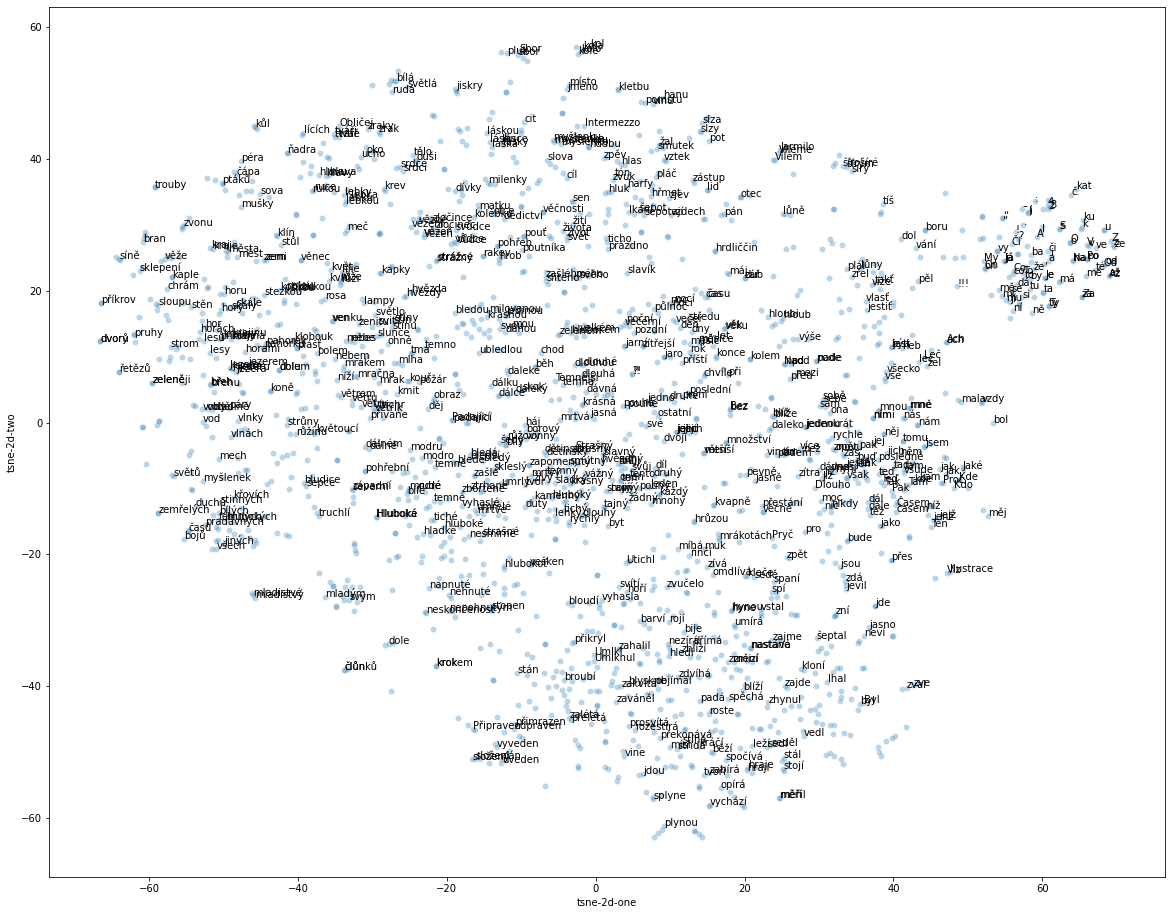

In [ ]:
df_subset["word"] = words
df_subset['tsne-2d-one'] = tsne_em[:,0]
df_subset['tsne-2d-two'] = tsne_em[:,1]
df_subset['count'] = [counts[w] for w in words]
## because the graph would be unreadable if displaying labels for all words
## you can change the number below
df_subset['disp_word'] = [w if counts[w]>1 else '' for w in words]
plt.figure(figsize=(20,16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(df_subset['tsne-2d-one'], df_subset['tsne-2d-two'], df_subset['disp_word'], plt.gca())  

Naturally, it seems that the word vectors make some clusters. Let's use some algorithm to find them. Afterwards, let's check that the clusters make sense.

In [ ]:
n_clusters=12 # feel free to change this number and re-run the cells below

In [ ]:
k = KMeans(n_clusters=n_clusters).fit(word_vectors)
k.labels_
df_subset['cluster']=k.labels_

In [ ]:
pd.options.display.max_rows = 40

In [ ]:
df_subset[['word', 'count', 'cluster']]

word  count  cluster
0     Svedenou      1        7
1          syn      1        1
2        stály      1        2
3            Z      5        5
4          zdá      2        3
...        ...    ...      ...
1913     mocný      1        1
1914      vrch      1        1
1915     bílým      1        7
1916       jen      9        3
1917     umoří      1        7

[1918 rows x 3 columns]

In [ ]:
df_subset.loc[df_subset['cluster']==9][['word', 'count', 'cluster']].sort_values(by='count')

word  count  cluster
0     Svedenou      1        9
1151   chladné      1        9
1160     smrtí      1        9
1163  šepotání      1        9
1164    večera      1        9
...        ...    ...      ...
102      noční      9        9
658    strašný      9        9
891      lásky     11        9
1508     kolem     16        9
1061      jeho     20        9

[767 rows x 3 columns]

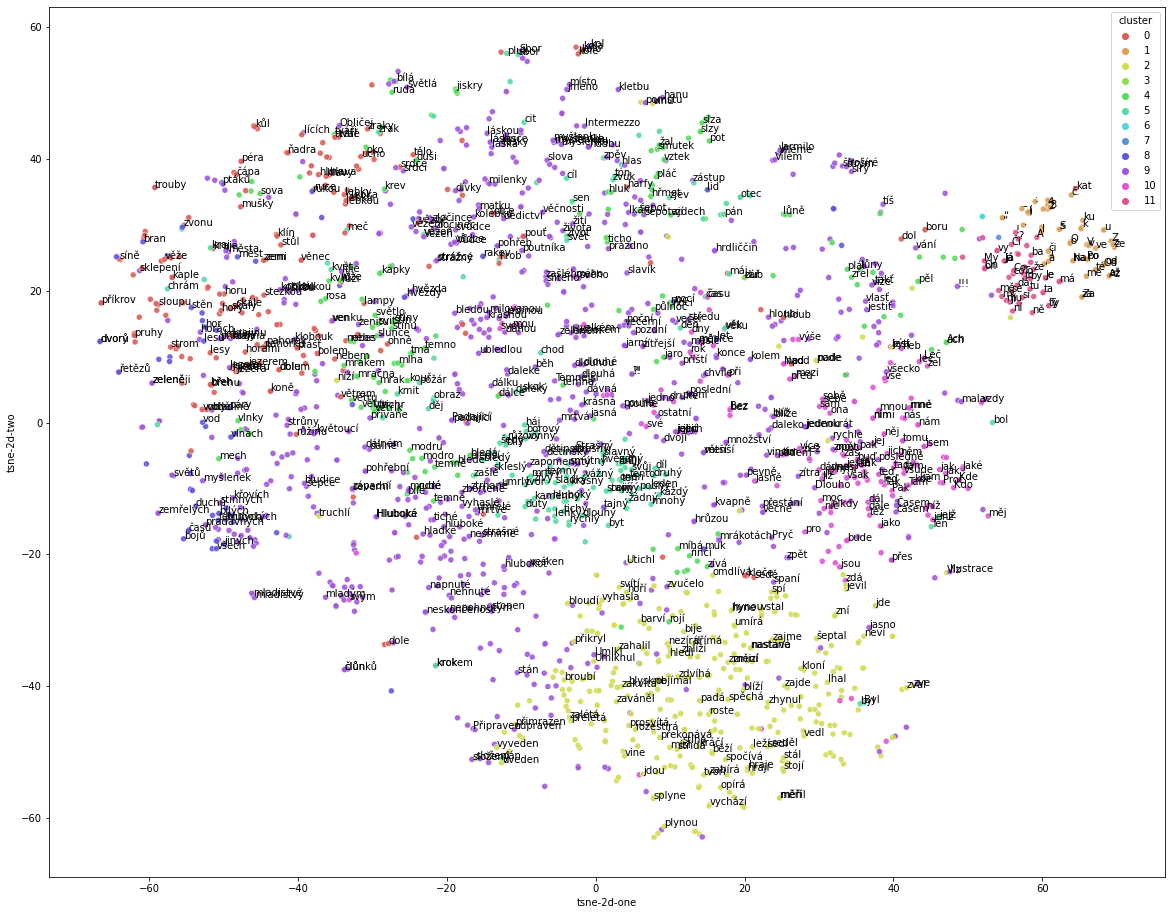

In [ ]:
plt.figure(figsize=(20,16))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", n_clusters),
    data=df_subset,
    legend="full",
    alpha=0.9,
    hue='cluster'
)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(df_subset['tsne-2d-one'], df_subset['tsne-2d-two'], df_subset['disp_word'], plt.gca())  